# Michigan Timeseries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [93]:
import pmdarima as pm

### Loading data

In [2]:
df_emp=pd.read_pickle("emp_dfpkl.sec")

In [3]:
df_emp= df_emp[['Michigan','California','Ohio','Texas','Indiana']]

In [4]:
emp_final= df_emp[238:]

#### Michigan Dataset

In [5]:
michigan=emp_final['Michigan']

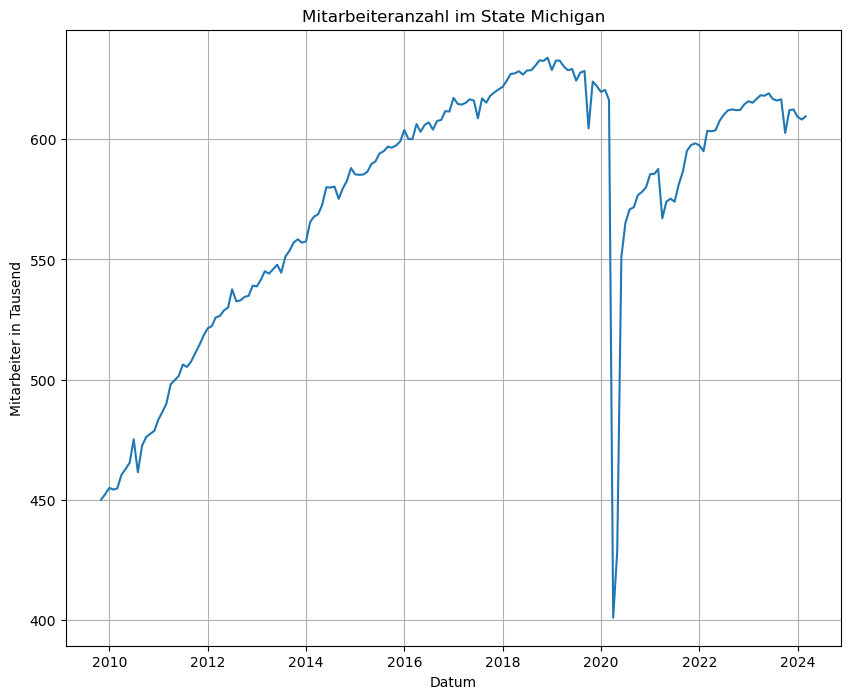

In [7]:
plt.figure(figsize=(10, 8))
plt.plot(michigan)
plt.title('Mitarbeiteranzahl im State Michigan')
plt.xlabel('Datum')
plt.ylabel('Mitarbeiter in Tausend')
plt.grid(True)
plt.show()

### Test und Trainingsdaten

In [8]:
#Test und Traingsdaten
train = michigan[:int(0.9 * len(michigan))]
test = michigan[int(0.9 * len(michigan)):]

In [32]:
pred_start= test.index[0]
pred_end= test.index[-1]

In [9]:
print(f"Länge des Trainingsdatensatzes: {len(train)}")
print(f"Länge des Testdatensatzes: {len(test)}")

Länge des Trainingsdatensatzes: 155
Länge des Testdatensatzes: 18


# Samira

### Besteht aus ARIMA (AR -> Autoregression, I -> Differenzierung und MA-> Gleitender Durschschnitt) plus Saisonale Komponenten S auf ARIMA 

## 1. Stationary

In [10]:
result = adfuller(michigan)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -2.444216595947254
p-value: 0.12964338441697898


keine stationarity

In [12]:
michigan_diff= michigan.diff().dropna()

In [13]:
result = adfuller(michigan_diff)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -8.480569820781676
p-value: 1.3968036346176326e-13


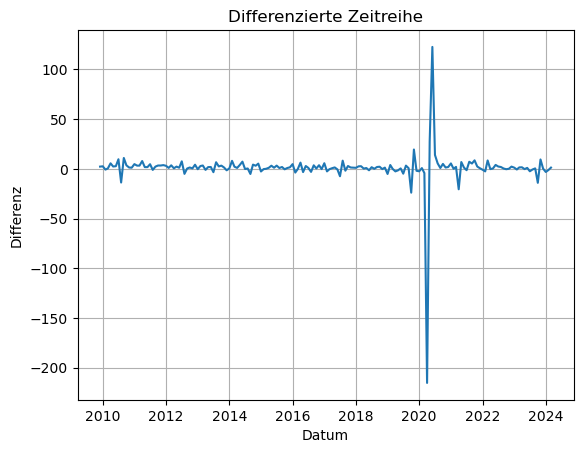

In [14]:
plt.plot(michigan_diff)
plt.title('Differenzierte Zeitreihe')
plt.xlabel('Datum')
plt.ylabel('Differenz')
plt.grid(True)
plt.show()

## 2. PACF und ACF

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

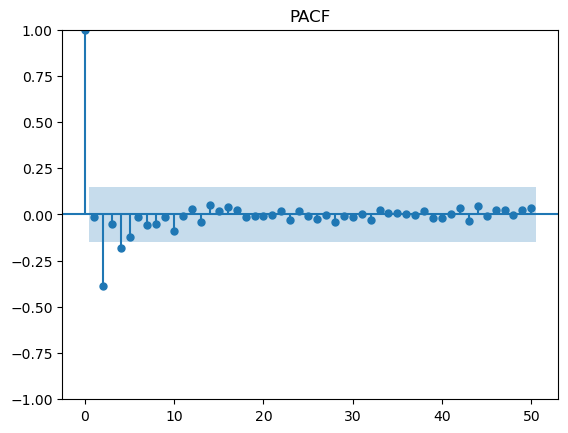

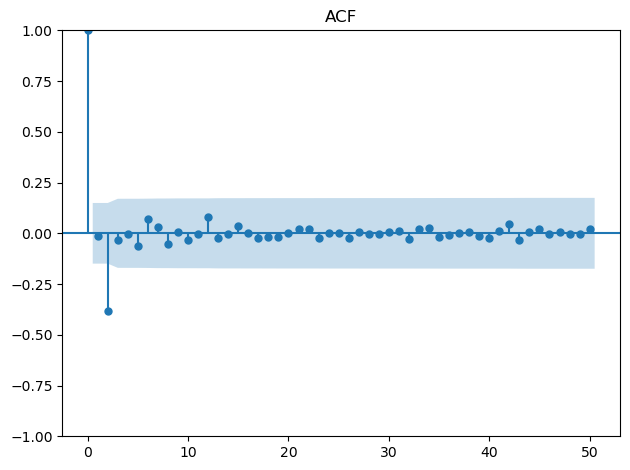

In [31]:
plot_pacf(michigan_diff,lags=50,title='PACF')
plot_acf(michigan_diff,lags=50,title='ACF')
plt.tight_layout()
plt.show()

### Gleitender Durchschnitt mit rolling window

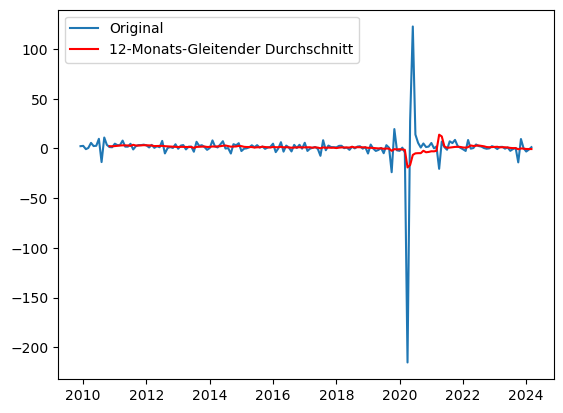

In [15]:
MA = michigan_diff.rolling(window=12).mean()
plt.plot(michigan_diff, label='Original')
plt.plot(MA, label='12-Monats-Gleitender Durchschnitt', color='red')
plt.legend()
plt.show()

### Gleitender durschnitt mit ARIMA

In [110]:
from statsmodels.tsa.arima.model import ARIMA

In [111]:
MA_modell= ARIMA(train,order=(0,0,2)) # -> nur MA berechnung

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [113]:
MA_fit= MA_modell.fit()
print(MA_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Michigan   No. Observations:                  155
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -727.424
Date:                Sat, 05 Oct 2024   AIC                           1462.848
Time:                        22:40:07   BIC                           1475.022
Sample:                    11-01-2009   HQIC                          1467.793
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        569.4016      7.845     72.581      0.000     554.026     584.777
ma.L1          1.2035      0.046     26.137      0.000       1.113       1.294
ma.L2          0.5579      0.045     12.319      0.0

P > Z sagt aus welche Lags signifikant sind. alles unter 0.05 sind nicht signifikant

In [38]:
ma_pred=MA_fit.predict(start=pred_start, end= pred_end)
residuals=test-ma_pred

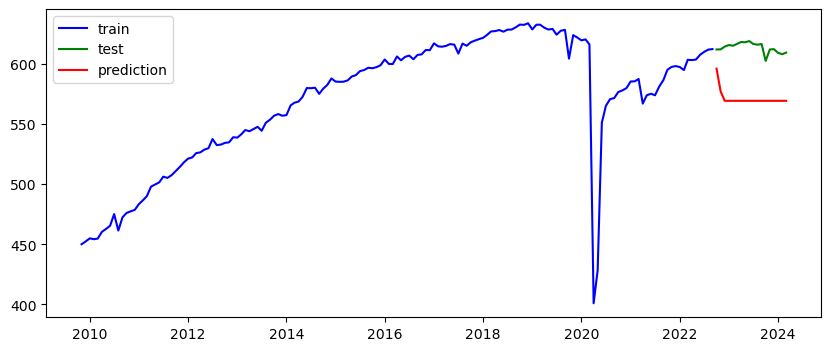

In [41]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( ma_pred, label='prediction',color='red')
plt.legend()
plt.show()

# AR -> Autoregression 

In [45]:
ar_modell= ARIMA(train,order=(2,0,0))
ar_fit=ar_modell.fit()
print(ar_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Michigan   No. Observations:                  155
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -688.060
Date:                Sat, 05 Oct 2024   AIC                           1384.120
Time:                        21:27:11   BIC                           1396.294
Sample:                    11-01-2009   HQIC                          1389.065
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        564.1929     52.613     10.723      0.000     461.074     667.312
ar.L1          0.9613      0.094     10.264      0.000       0.778       1.145
ar.L2         -0.0296      0.072     -0.410      0.6

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Prediction with Ar models

In [48]:
ar_pred=ar_fit.predict(start=pred_start, end= pred_end)
residuals=test-ar_pred

Ploting

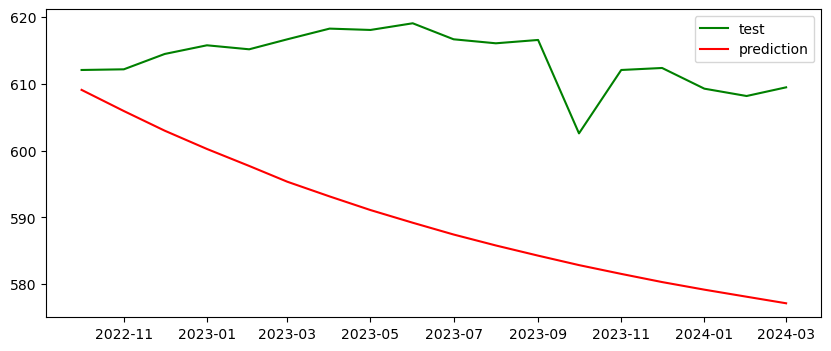

In [64]:
plt.figure(figsize=(10,4))
#plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( ar_pred, label='prediction',color='red')
plt.legend()
plt.show()

### Evaulation

In [77]:
test_mae = mean_absolute_error(test, ar_pred)
test_mse = mean_squared_error(test, ar_pred)
test_rmse = mean_squared_error(test, ar_pred, squared=False)
test_r2 = r2_score(test, ar_pred)

In [78]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 23.553990745445372
mse 637.191069467263
rmse 25.242643868407743
r2 -36.16570321563918


# Arima (p,d,q)

In [74]:
arima_modell= ARIMA(train, order=(2,1,2)) #best order 3,0,1
arima_fit=arima_modell.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Michigan   No. Observations:                  155
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -669.648
Date:                Sat, 05 Oct 2024   AIC                           1349.295
Time:                        21:38:37   BIC                           1364.480
Sample:                    11-01-2009   HQIC                          1355.463
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1467      0.449      0.326      0.744      -0.734       1.028
ar.L2         -0.0911      0.194     -0.470      0.639      -0.471       0.289
ma.L1         -0.2111      0.438     -0.482      0.6

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [75]:
arima_pred=arima_fit.predict(start=pred_start, end= pred_end)
residuals=test-arima_pred

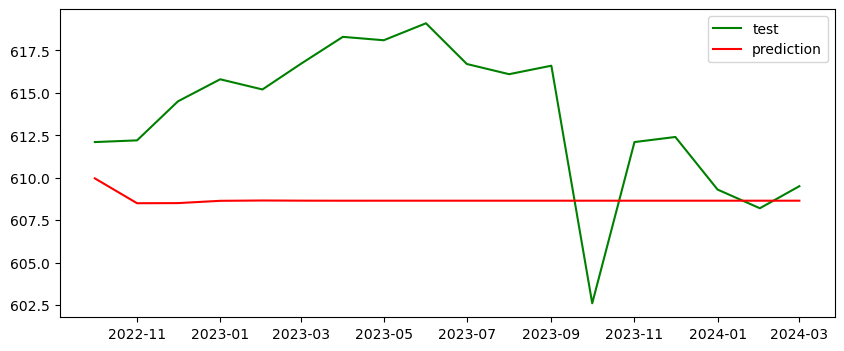

In [76]:
plt.figure(figsize=(10,4))
#plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( arima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [79]:
test_mae = mean_absolute_error(test, arima_pred)
test_mse = mean_squared_error(test, arima_pred)
test_rmse = mean_squared_error(test, arima_pred, squared=False)
test_r2 = r2_score(test, arima_pred)

In [80]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 5.657940195945027
mse 41.82691259357957
rmse 6.467372928290093
r2 -1.439655378690655


# Sarima (p,d,q)(P,D,Q)s

In [82]:
my_order = (2,1,2)
my_sorder = (1,1,1,12)

In [86]:
sarima_modell = SARIMAX(train, order=my_order, seasonal_order=my_sorder)
sarima_fit=sarima_modell.fit()
print(sarima_fit.summary())

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                             Michigan   No. Observations:                  155
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -630.658
Date:                              Sat, 05 Oct 2024   AIC                           1275.316
Time:                                      22:11:41   BIC                           1296.007
Sample:                                  11-01-2009   HQIC                          1283.724
                                       - 09-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1713      1.024      0.167      0.867      -1.835       2.178
ar.L2         -0.09

In [88]:
sarima_pred=sarima_fit.predict(start=pred_start, end= pred_end)
residuals=test-sarima_pred

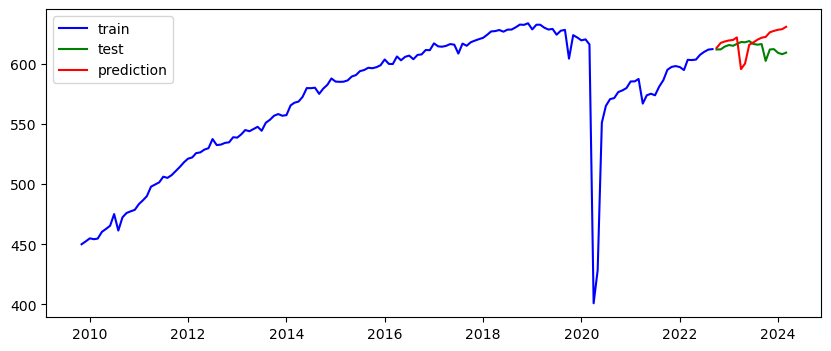

In [90]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( sarima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [91]:
test_mae = mean_absolute_error(test, sarima_pred)
test_mse = mean_squared_error(test, sarima_pred)
test_rmse = mean_squared_error(test, sarima_pred, squared=False)
test_r2 = r2_score(test, sarima_pred)

In [92]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 10.543290905395944
mse 171.44483450292805
rmse 13.093694455841256
r2 -8.999932739668703


# Auto Sarima

In [95]:
auto_sarima = pm.auto_arima(train,d=None, stationary= False,
                           m=12, start_p=0, max_p=11, max_d= 1,approximation = True, start_q=0, max_q=11, start_P=0, D=None, start_Q=0, max_P=11, max_D=1, max_Q=11, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1373.379, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1376.385, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1376.339, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1371.780, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1374.400, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1374.404, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1376.400, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1375.359, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1375.290, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1361.390, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1362.151, Time=0.14 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1362.142, Time=0.17 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1364.142, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1350.961, Time=0.07 sec
 ARIMA(2,1,1)(1,0,0

In [105]:
my_order = (4,1,1)
my_sorder = (1,1,1,12)

In [106]:
a_sarima = SARIMAX(train, order=my_order, seasonal_order=my_sorder)
auto_s_fit = a_sarima.fit()
print(auto_s_fit.summary())

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           Michigan   No. Observations:                  155
Model:             SARIMAX(4, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -630.272
Date:                            Sat, 05 Oct 2024   AIC                           1276.544
Time:                                    22:26:59   BIC                           1300.190
Sample:                                11-01-2009   HQIC                          1286.153
                                     - 09-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5094      0.346      1.473      0.141      -0.169       1.187
ar.L2         -0.4412      0.136   

In [107]:
auto_sarima_pred=auto_s_fit.predict(start=pred_start, end= pred_end)
residuals=test-auto_sarima_pred

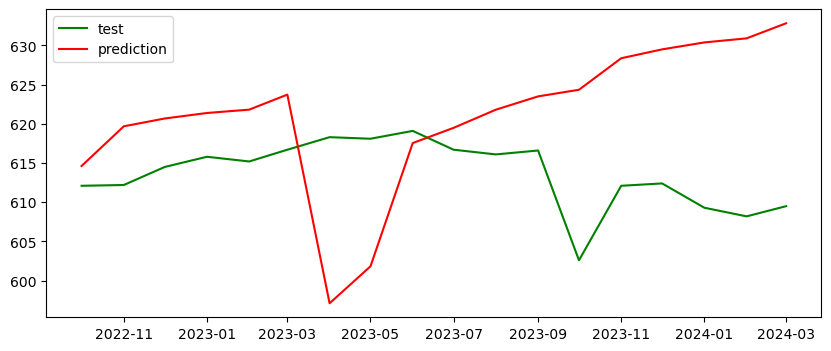

In [108]:
plt.figure(figsize=(10,4))
#plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( auto_sarima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [103]:
test_mae = mean_absolute_error(test, auto_sarima_pred)
test_mse = mean_squared_error(test, auto_sarima_pred)
test_rmse = mean_squared_error(test, auto_sarima_pred, squared=False)
test_r2 = r2_score(test, auto_sarima_pred)

In [104]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 5.191608822561142
mse 35.74109411569407
rmse 5.9783855777035715
r2 -1.08468536386849
